In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import matplotlib.cm as cm
import seaborn as sns
from matplotlib import gridspec
import matplotlib.animation as manimation
import time
import scipy.io as sio
from random import shuffle
import time
from collections import Counter
import sklearn.cluster as cluster
import time
import hdbscan
from os import listdir
from os.path import isfile, join
import os
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from pathlib import Path
from matplotlib_venn import venn2, venn2_circles, venn3, venn3_circles


In [3]:
def uniqueValsdf(df):
    uniquelist = list(df.iloc[:,0].dropna().unique())
    for col in range(1,len(df.columns)):
        uniquelist = uniquelist+list(df.iloc[:,col].dropna().unique())
    return(uniquelist)

In [4]:
# if mapping has been done recently before:
mypath = '/home/datastorage/IMG_ANNOTATION_DATA/Obsidian_MAGs/'
typedata = 'conservative'
Mmap = pd.read_pickle(mypath+'Knumbers/module_map_'+typedata)
Mlist = pd.read_pickle(mypath+'Knumbers/module_list_'+typedata)

typedata = 'complete'
Mmap_comp = pd.read_pickle(mypath+'Knumbers/module_map_'+typedata)
Mlist_comp = pd.read_pickle(mypath+'Knumbers/module_list_'+typedata)

# if mapping has been done recently before:
mypath = 'MAGs/extractclades/'
typedata = 'conservative'
Mlist_clade = pd.read_pickle(mypath+'Knumbers/module_list_'+typedata)
Mmap_clade = pd.read_pickle(mypath+'Knumbers/module_map_'+typedata)
typedata = 'complete'
Mmap_clade_comp = pd.read_pickle(mypath+'Knumbers/module_map_'+typedata)
Mlist_clade_comp = pd.read_pickle(mypath+'Knumbers/module_list_'+typedata)

In [26]:
COGcat = pd.read_table('COGreffiles/fun2003-2014.tab')
COGtab = pd.read_table('COGreffiles/cognames2003-2014.tab')
COGtab['NameNum'] = COGtab['name']+' - '+COGtab['COG']
COGtab['FuncCat'] = [COGcat[COGcat['# Code']==i[0]]['Name'].values[0] for i in COGtab['func']]
COGtab.FuncCat.value_counts()

Function unknown                                                 959
General function prediction only                                 507
Translation, ribosomal structure and biogenesis                  326
Energy production and conversion                                 268
Amino acid transport and metabolism                              265
Carbohydrate transport and metabolism                            239
Inorganic ion transport and metabolism                           210
Cell wall/membrane/envelope biogenesis                           204
Coenzyme transport and metabolism                                204
Transcription                                                    186
Replication, recombination and repair                            176
Posttranslational modification, protein turnover, chaperones     172
Signal transduction mechanisms                                   144
Nucleotide transport and metabolism                              115
Mobilome: prophages, transposons  

In [6]:
mypath = '/home/datastorage/IMG_ANNOTATION_DATA/Obsidian_MAGs/'
foldernames = [f for f in listdir(mypath) if ('Knumbers') not in f and ('NN_MAGs') not in f]

foldername = pd.DataFrame(index=range(len(foldernames)),columns=['folder_name','number','genome'])
foldername['folder_name'] = [f for f in foldernames]
foldername['number'] = [f[-10:] for f in foldernames]
foldername['genome'] = [f[0:15] for f in foldernames]
ktab = pd.DataFrame(index=range(10000),columns=list(foldername['genome']))
ctab = pd.DataFrame(index=range(10000),columns=list(foldername['genome']))
ptab = pd.DataFrame(index=range(10000),columns=list(foldername['genome']))
ctab_thr = pd.DataFrame(index=range(10000),columns=list(foldername['genome'])) # threshold hit value

# make KO-list table and write to txt file in Knumbers folder
for i in range(0,len(foldername)):
    kofile = mypath+foldername.loc[i,'folder_name']+'/IMG_Data/'+foldername.loc[i,'number']+'/'+foldername.loc[i,'number']+'.ko.tab.txt'        
    ktab[foldername.loc[i,'genome']] = pd.read_csv(kofile,'\t')['ko_id'].str[3:]
    ktab[foldername.loc[i,'genome']].to_csv(mypath+'Knumbers/'+foldername.loc[i,'genome']+'.txt',sep='\t')
    # make COG-list table 
    cofile = mypath+foldername.loc[i,'folder_name']+'/IMG_Data/'+foldername.loc[i,'number']+'/'+foldername.loc[i,'number']+'.cog.tab.txt'        
    ctab[foldername.loc[i,'genome']] = pd.read_csv(cofile,'\t')['cog_id']
    ctab_thr[foldername.loc[i,'genome']] = pd.read_csv(cofile,'\t')['percent_identity']
    #ctab[foldername.loc[i,'genome']].to_csv(mypath+'Knumbers/'+foldername.loc[i,'genome']+'.txt',sep='\t')
    # make pfam-list table 
    pffile = mypath+foldername.loc[i,'folder_name']+'/IMG_Data/'+foldername.loc[i,'number']+'/'+foldername.loc[i,'number']+'.pfam.tab.txt'        
    pfamtemp =  pd.read_csv(pffile,'\t')[['pfam_id','pfam_name']]
    pfamtemp['namenum'] = pfamtemp['pfam_id']+', '+pfamtemp['pfam_name']
    ptab[foldername.loc[i,'genome']] = pfamtemp['namenum']


# COG dfs with different percent identity threshold values 
ctab_30 = ctab[ctab_thr>30]
ctab_40 = ctab[ctab_thr>40]
ctab_50 = ctab[ctab_thr>50]
ctab_60 = ctab[ctab_thr>60]
ctab_70 = ctab[ctab_thr>70]
ctab_80 = ctab[ctab_thr>80]

In [7]:
cladeDF = pd.read_table('MAGs/extractclades/ObsidianPool_selected_groups.tsv')
cladeDF_tot = pd.read_table('MAGs/extractclades/ObsidianPool_allclades.tsv')
# make one ktab for all clades, including my own Obsidian Pool genomes
ktab_clade = pd.DataFrame(index=range(10000),columns=list(cladeDF['Bin_ID']))
ctab_clade = pd.DataFrame(index=range(10000),columns=list(cladeDF['Bin_ID']))
ptab_clade = pd.DataFrame(index=range(10000),columns=list(cladeDF['Bin_ID']))
ctab_clade_thr = pd.DataFrame(index=range(10000),columns=list(cladeDF['Bin_ID']))

for bins in ktab_clade.columns:
    if bins[0:3]=='Obs':
        # this assumes the ktab and ctab dfs have been made 
        ktab_clade[bins] = ktab[bins]
        ctab_clade[bins] = ctab[bins]
        ptab_clade[bins] = ptab[bins]
        ctab_clade_thr[bins] = ctab_thr[bins]
    elif bins[0:3]=='UBA':
        ktab_clade.drop(bins,axis=1,inplace=True)
        ctab_clade.drop(bins,axis=1,inplace=True)
        ptab_clade.drop(bins,axis=1,inplace=True)
        ctab_clade_thr.drop(bins,axis=1,inplace=True)
    else:
        # go to extractclade 
        path = 'MAGs/extractclades/'
        subfolder = cladeDF[cladeDF['Bin_ID']==bins]['Group'].values[0]
        kofile = path+subfolder+'/'+bins+'/'+bins+'.ko.tab.txt'
        cofile = path+subfolder+'/'+bins+'/'+bins+'.cog.tab.txt'
        pffile = path+subfolder+'/'+bins+'/'+bins+'.pfam.tab.txt'
        ktab_clade[bins] = pd.read_csv(kofile,'\t')['ko_id'].str[3:]
        ktab_clade[bins].to_csv(path+'Knumbers/'+bins+'.txt',sep='\t')
        ctab_clade[bins] = pd.read_csv(cofile,'\t')['cog_id']
        ctab_clade_thr[bins] = pd.read_csv(cofile,'\t')['percent_identity']
        
        pfamtemp =  pd.read_csv(pffile,'\t')[['pfam_id','pfam_name']]
        pfamtemp['namenum'] = pfamtemp['pfam_id']+', '+pfamtemp['pfam_name']
        ptab_clade[bins] = pfamtemp['namenum']

# COG dfs with different percent identity threshold values 
ctab_clade_30 = ctab_clade[ctab_clade_thr>30]
ctab_clade_40 = ctab_clade[ctab_clade_thr>40]
ctab_clade_50 = ctab_clade[ctab_clade_thr>50]
ctab_clade_60 = ctab_clade[ctab_clade_thr>60]
ctab_clade_70 = ctab_clade[ctab_clade_thr>70]
ctab_clade_80 = ctab_clade[ctab_clade_thr>80]

In [8]:
# all the clades in the tree 
cols = [0,'Class','Order','Family','Genus','Species','IMG_ID']
lookup_clades = pd.read_table('Tree_Obsidian/TreesV3/allarcheaMarch2018_V3/archaea_March2018.lookup',sep='|',header=None)
lookupGC_cla = pd.read_table('Tree_Obsidian/TreesV3/allarcheaMarch2018_V3/archaea_March2018.GCLen',header=None).set_index(0)
keys = lookup_clades.columns
lut = dict(zip(keys,cols))
lookup_clades = lookup_clades.rename(columns=lut)
lc = pd.DataFrame(lookup_clades[0].str.split('\t',1).tolist(),columns =['IMG','Phylum'])
lookup_clades = lc.join(lookup_clades)
lookup_clades = lookup_clades.drop([0], axis=1)
lookup_clades = lookup_clades.set_index('IMG',drop=True)
lookup_clades = lookup_clades.join(lookupGC_cla,how='inner')
lookup_clades = lookup_clades.rename(columns={1:'GC',2:'length'})
lookup_clades['IMG_ID'] = lookup_clades['IMG_ID'].astype(str).str[0:-2]
cladeDF_true = cladeDF[~cladeDF['Bin_ID'].str.contains('UBA')]
cladeDF_IMG = cladeDF_true[~(cladeDF_true['Bin_ID'].str.contains('Obs'))]

In [9]:
verstraetearch_tot = cladeDF_true[cladeDF_true['Group'].str.contains('Vers')]
verstraete_V = list(verstraetearch_tot[2:8]['Bin_ID'])
lute = list(verstraetearch_tot[0:1]['Bin_ID'])+list(verstraetearch_tot[8:11]['Bin_ID'])
lute


['2721755900', '2721755437', '2721755438', 'Obs2_genome_008']

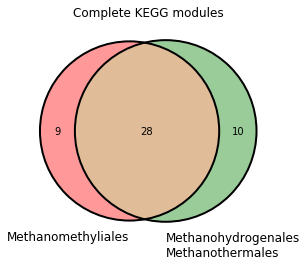

In [10]:
verclade_tot = uniqueValsdf(Mlist_clade_comp[verstraete_V])
lute_tot = uniqueValsdf(Mlist_clade_comp[lute])
f = plt.figure()
venn2([set(verclade_tot),set(lute_tot)],set_labels=('Methanomethyliales','Methanohydrogenales\nMethanothermales'))
venn2_circles([set(verclade_tot),set(lute_tot)])
plt.title('Complete KEGG modules')
plt.show()
#f.savefig('MAGs/Analysis/Venns/20180618_Lute_KEGG_complete.pdf')

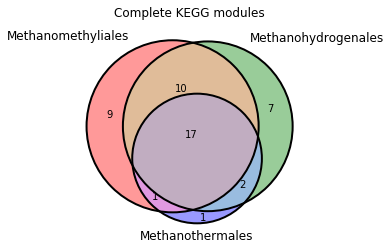

In [11]:
verclade_tot = uniqueValsdf(Mlist_clade_comp[verstraete_V])
MH_tot = uniqueValsdf(Mlist_clade_comp[lute[1:]])
MT_tot = list(Mlist_clade_comp[lute[0]].dropna())
f = plt.figure()
venn3([set(verclade_tot),set(MH_tot),set(MT_tot)],set_labels=('Methanomethyliales','Methanohydrogenales','Methanothermales'))
venn3_circles([set(verclade_tot),set(MH_tot),set(MT_tot)])
plt.title('Complete KEGG modules')
plt.show()
#f.savefig('MAGs/Analysis/Venns/20180703_Verstraete_KEGG_complete.pdf')

# COG analysis - 30%

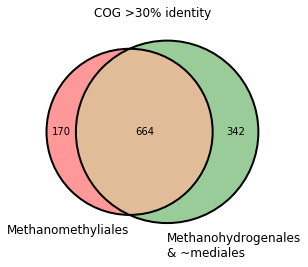

In [82]:
vercladeCOG = uniqueValsdf(ctab_clade_30[verstraete_V])
verobsCOG = uniqueValsdf(ctab_clade_30[lute])
f = plt.figure()
venn2([set(vercladeCOG),set(verobsCOG)],set_labels=('Methanomethyliales','Methanohydrogenales\n& ~mediales'))
venn2_circles([set(vercladeCOG),set(verobsCOG)])
plt.title('COG >30% identity')
plt.show()
#f.savefig('MAGs/Analysis/Venns/20180618_Lute_COG30.pdf')

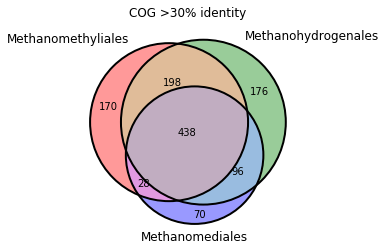

In [111]:
methylialesCOG = set(uniqueValsdf(ctab_clade_30[verstraete_V]))
medialesCOG = set(ctab_clade_30[lute[0]].dropna().unique())
hydrogenalesCOG = set(uniqueValsdf(ctab_clade_30[lute[1:]]))
f = plt.figure()
venn3([methylialesCOG,hydrogenalesCOG,medialesCOG],set_labels=('Methanomethyliales','Methanohydrogenales','Methanomediales'))
venn3_circles([methylialesCOG,hydrogenalesCOG,medialesCOG])
plt.title('COG >30% identity')
plt.show()
f.savefig('MAGs/Analysis/Venns/20181025_Verstraete_COG30.pdf')

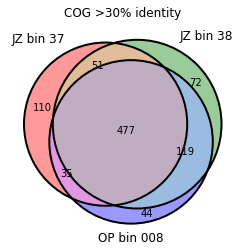

In [84]:
# compare the individual methanohydrogenales with each other
jzbin37 = set(ctab_clade_30[lute[1]].dropna().unique())
jzbin38 = set(ctab_clade_30[lute[2]].dropna().unique())
opbin08 = set(ctab_clade_30[lute[3]].dropna().unique())
f = plt.figure()
venn3([jzbin37,jzbin38,opbin08],set_labels=('JZ bin 37','JZ bin 38','OP bin 008'))
venn3_circles([jzbin37,jzbin38,opbin08])
plt.title('COG >30% identity')
plt.show()
f.savefig('MAGs/Analysis/Venns/20181025_Methanohydrogenales_COG30.pdf')

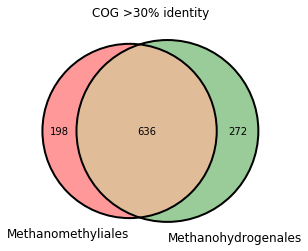

In [85]:
# compare methanomethyliales with ~hydrogenales
f = plt.figure()
venn2([methylialesCOG,hydrogenalesCOG],set_labels=('Methanomethyliales','Methanohydrogenales'))
venn2_circles([methylialesCOG,hydrogenalesCOG])
plt.title('COG >30% identity')
plt.show()
f.savefig('MAGs/Analysis/Venns/20181025_Verstraete_MethylVsHydro_COG30.pdf')

In [86]:
COGtab[COGtab['COG'].isin(hydrogenalesCOG.difference(methylialesCOG))].to_csv('MAGs/Analysis/Venns/20181025_COGall_uniquehitsinclade_Methanohydrogenales',sep='\t')
#COGtab[COGtab['COG'].isin(COGclade.difference(COGbins))].to_csv('MAGs/Analysis/Venns/20180618_COGall_missinghitsinclade_Lutearchaeota',sep='\t')
#COGtab[COGtab['COG'].isin(COGclade.intersection(COGbins))].to_csv('MAGs/Analysis/Venns/20180618_COGall_intersect_Lutearchaeota',sep='\t')

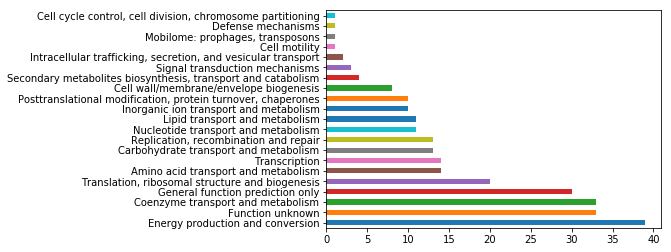

In [87]:
COGtab[COGtab['COG'].isin(hydrogenalesCOG.difference(methylialesCOG))].FuncCat.value_counts().plot.barh()
plt.show()

In [122]:
unique_to_hydrogenales = hydrogenalesCOG.difference(methylialesCOG)
unique_to_hydrogenales_nomediales = hydrogenalesCOG.difference(methylialesCOG).difference(medialesCOG)

In [89]:
shared_between_hydrogenales = jzbin37.intersection(jzbin38.intersection(opbin08))

In [123]:
len(shared_between_hydrogenales)
len(unique_to_hydrogenales_nomediales)

176

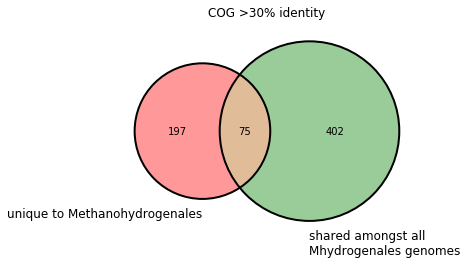

In [91]:
# how commonly are the genes that are unique to the methanohydrogenales shared between each other?
f = plt.figure()
venn2([unique_to_hydrogenales,shared_between_hydrogenales],set_labels=('unique to Methanohydrogenales','shared amongst all\nMhydrogenales genomes'))
venn2_circles([unique_to_hydrogenales,shared_between_hydrogenales])
plt.title('COG >30% identity')
plt.show()
f.savefig('MAGs/Analysis/Venns/20181025_Methanohydro_coregenes_COG30.pdf')

In [124]:
unique_and_shared = unique_to_hydrogenales.intersection(shared_between_hydrogenales)
unique_and_shared_nomediales = unique_to_hydrogenales_nomediales.intersection(shared_between_hydrogenales)

In [125]:
len(unique_and_shared)
len(unique_and_shared_nomediales)

31

In [127]:
COGtab[COGtab['COG'].isin(unique_and_shared_nomediales)].sort_values('FuncCat')

,COG,func,name,NameNum,FuncCat
74,COG0076,E,Glutamate or tyrosine decarboxylase or a relat...,Glutamate or tyrosine decarboxylase or a relat...,Amino acid transport and metabolism
2104,COG2301,G,Citrate lyase beta subunit,Citrate lyase beta subunit - COG2301,Carbohydrate transport and metabolism
1910,COG2079,G,2-methylcitrate dehydratase PrpD,2-methylcitrate dehydratase PrpD - COG2079,Carbohydrate transport and metabolism
1940,COG2109,H,ATP:corrinoid adenosyltransferase,ATP:corrinoid adenosyltransferase - COG2109,Coenzyme transport and metabolism
1306,COG1469,H,GTP cyclohydrolase FolE2,GTP cyclohydrolase FolE2 - COG1469,Coenzyme transport and metabolism
1628,COG1795,C,Formaldehyde-activating enzyme nesessary for m...,Formaldehyde-activating enzyme nesessary for m...,Energy production and conversion
1228,COG1390,C,Archaeal/vacuolar-type H+-ATPase subunit E/Vma4,Archaeal/vacuolar-type H+-ATPase subunit E/Vma...,Energy production and conversion
1712,COG1880,C,CO dehydrogenase/acetyl-CoA synthase epsilon s...,CO dehydrogenase/acetyl-CoA synthase epsilon s...,Energy production and conversion
475,COG0479,C,"Succinate dehydrogenase/fumarate reductase, Fe...","Succinate dehydrogenase/fumarate reductase, Fe...",Energy production and conversion
984,COG1141,C,Ferredoxin,Ferredoxin - COG1141,Energy production and conversion


In [109]:
COGtab[COGtab['COG'].isin(unique_and_shared)].to_csv('MAGs/Analysis/Venns/20181025_COG30_uniquehitsinclade_sharedbetweenall_Methanohydrogenales',sep='\t')

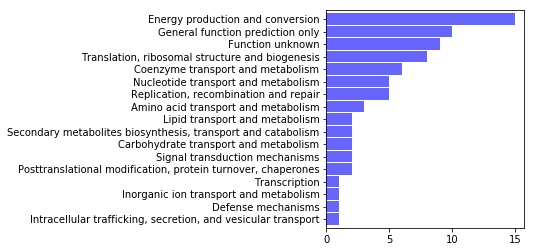

In [108]:
f = plt.figure()
f.set_figheight(4)
f.set_figwidth(11)
COGtab[COGtab['COG'].isin(unique_and_shared)].FuncCat.value_counts().plot.barh(color='b',width=.9,alpha=.6)
plt.gca().invert_yaxis()
plt.gcf().subplots_adjust(left = 0.7,right=0.95)#top=0.9,bottom=0.3)
plt.show()
f.savefig('MAGs/Analysis/Venns/20181025_COG30_core__unique_methanohydrogenales.pdf')

In [112]:
len(medialesCOG.difference(methylialesCOG.difference(hydrogenalesCOG)))

604

In [117]:
unique_mediales = medialesCOG.difference(methylialesCOG).difference(hydrogenalesCOG)

In [120]:
COGtab[COGtab['COG'].isin(unique_mediales)].sort_values('FuncCat').to_csv('MAGs/Analysis/Venns/20181025_COG30_uniquehits_Methanomediales',sep='\t')

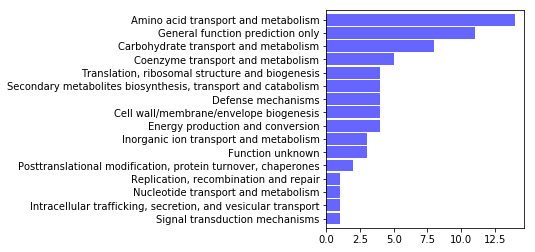

In [121]:
f = plt.figure()
f.set_figheight(4)
f.set_figwidth(11)
COGtab[COGtab['COG'].isin(unique_mediales)].FuncCat.value_counts().plot.barh(color='b',width=.9,alpha=.6)
plt.gca().invert_yaxis()
plt.gcf().subplots_adjust(left = 0.7,right=0.95)#top=0.9,bottom=0.3)
plt.show()
f.savefig('MAGs/Analysis/Venns/20181025_COG30_core__unique_methanomediales.pdf')

# COG analysis - all hits

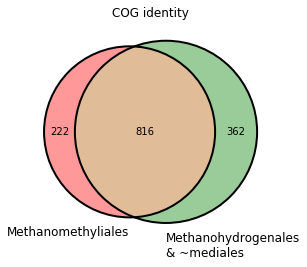

In [74]:
vercladeCOG = uniqueValsdf(ctab_clade[verstraete_V])
verobsCOG = uniqueValsdf(ctab_clade[lute])
f = plt.figure()
venn2([set(vercladeCOG),set(verobsCOG)],set_labels=('Methanomethyliales','Methanohydrogenales\n& ~mediales'))
venn2_circles([set(vercladeCOG),set(verobsCOG)])
plt.title('COG identity')
plt.show()
#f.savefig('MAGs/Analysis/Venns/20180618_Lute_COG30.pdf')

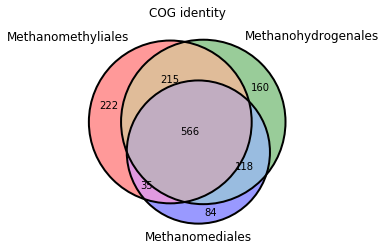

In [75]:
methylialesCOG = set(uniqueValsdf(ctab_clade[verstraete_V]))
medialesCOG = set(ctab_clade[lute[0]].dropna().unique())
hydrogenalesCOG = set(uniqueValsdf(ctab_clade[lute[1:]]))
f = plt.figure()
venn3([methylialesCOG,hydrogenalesCOG,medialesCOG],set_labels=('Methanomethyliales','Methanohydrogenales','Methanomediales'))
venn3_circles([methylialesCOG,hydrogenalesCOG,medialesCOG])
plt.title('COG identity')
plt.show()
f.savefig('MAGs/Analysis/Venns/20181025_Verstraete_COGall.pdf')

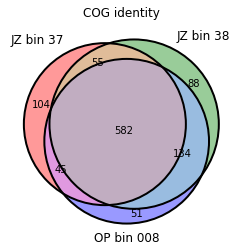

In [76]:
# compare the individual methanohydrogenales with each other
jzbin37 = set(ctab_clade[lute[1]].dropna().unique())
jzbin38 = set(ctab_clade[lute[2]].dropna().unique())
opbin08 = set(ctab_clade[lute[3]].dropna().unique())
f = plt.figure()
venn3([jzbin37,jzbin38,opbin08],set_labels=('JZ bin 37','JZ bin 38','OP bin 008'))
venn3_circles([jzbin37,jzbin38,opbin08])
plt.title('COG identity')
plt.show()
f.savefig('MAGs/Analysis/Venns/20181025_Methanohydrogenales_COGall.pdf')

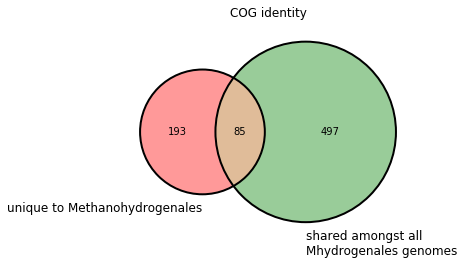

In [77]:
unique_to_hydrogenales = hydrogenalesCOG.difference(methylialesCOG)
shared_between_hydrogenales = jzbin37.intersection(jzbin38.intersection(opbin08))


# how commonly are the genes that are unique to the methanohydrogenales shared between each other?
f = plt.figure()
venn2([unique_to_hydrogenales,shared_between_hydrogenales],set_labels=('unique to Methanohydrogenales','shared amongst all\nMhydrogenales genomes'))
venn2_circles([unique_to_hydrogenales,shared_between_hydrogenales])
plt.title('COG identity')
plt.show()
f.savefig('MAGs/Analysis/Venns/20181025_Methanohydro_coregenes_COGall.pdf')

In [78]:
unique_and_shared = unique_to_hydrogenales.intersection(shared_between_hydrogenales)

In [79]:
COGtab[COGtab['COG'].isin(unique_and_shared)].to_csv('MAGs/Analysis/Venns/20181025_COGall_uniquehitsinclade_sharedbetweenall_Methanohydrogenales',sep='\t')